In [65]:
# Awareness Model Retraining with Budget-Aware Scaling
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [66]:
# Load your cleaned and encoded DataFrame
df = pd.read_csv("../data/meta_ads_cleaned.csv")
df.head()

,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2024/0281 - Campagne Ramadan - Instagram - ...,inactive,Instagram,In-app,Feed,Awareness,reach,0.28,Using ad set budget,0.28,...,0.000000,0,0.0,0.00,0,0.0,0.000000,0,0.000000,0.00
1,SO/2024/0318 - Campagne Ramadan 2 - BC : - In...,not_delivering,Audience Network,In-app,Feed,App Installs,actions:mobile_app_install,2.63,Using ad set budget,2.63,...,2.630000,0,0.0,0.00,0,0.0,0.000000,0,0.000000,0.00
2,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Audience Network,In-app,Feed,Sales,actions:offsite_conversion.fb_pixel_purchase,22.80,Using ad set budget,22.80,...,0.000000,60,1199.0,0.38,730,1756.0,0.031233,228,0.100000,4.56
3,SO/2024/0318 - Campagne Ramadan 2 - BC : - In...,not_delivering,Audience Network,In-app,Facebook Stories,App Installs,actions:mobile_app_install,25.83,Using ad set budget,25.83,...,0.993462,0,0.0,0.00,3,0.0,8.610000,0,0.000000,0.00
4,SO/2024/0556 - Orange - Lancement_campagne_Dat...,not_delivering,Instagram,Desktop,Feed,Awareness,reach,191.10,Using ad set budget,191.10,...,0.000000,5,0.0,38.22,103,0.0,1.855340,32,5.971875,0.00


In [67]:
awareness_df = df[df['Objective'] == 'Awareness'].copy()
awareness_df.reset_index(drop=True, inplace=True)
awareness_df.head()

,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2024/0281 - Campagne Ramadan - Instagram - ...,inactive,Instagram,In-app,Feed,Awareness,reach,0.28,Using ad set budget,0.28,...,0.000000,0,0.0,0.000000,0,0.0,0.000000,0,0.000000,0.000000
1,SO/2024/0556 - Orange - Lancement_campagne_Dat...,not_delivering,Instagram,Desktop,Feed,Awareness,reach,191.10,Using ad set budget,191.10,...,0.000000,5,0.0,38.220000,103,0.0,1.855340,32,5.971875,0.000000
2,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Audience Network,In-app,Ads on Reels,Awareness,reach,399.41,Using ad set budget,399.41,...,2.450368,43,0.0,9.288605,1653,1222.7,0.241627,408,0.978946,66.568333
3,SO/2024/0581 - Orange - Campagne Achat options...,not_delivering,Instagram,In-app,Feed,Awareness,reach,41.88,Using ad set budget,41.88,...,0.000000,2,0.0,20.940000,113,0.0,0.370619,6,6.980000,0.000000
4,SO/2024/0071 - Orange - Lancement_Campagne BB ...,not_delivering,Facebook,In-app,Facebook Reels,Awareness,reach,28.49,Using ad set budget,28.49,...,0.000000,2,755.1,14.245000,75,0.0,0.379867,86,0.331279,0.000000


In [87]:
categorical_cols = ['Platforme', 'Placement', 'Device', 'Ad set budget type']

awareness_df_encoded = pd.get_dummies(awareness_df, columns=categorical_cols, drop_first=True)

# --- Step 1.5: Add Date Features (if available)
if 'Starts' in awareness_df_encoded.columns:
    awareness_df_encoded['Starts'] = pd.to_datetime(awareness_df_encoded['Starts'])
    awareness_df_encoded['day'] = awareness_df_encoded['Starts'].dt.day
    awareness_df_encoded['month'] = awareness_df_encoded['Starts'].dt.month
    awareness_df_encoded['weekday'] = awareness_df_encoded['Starts'].dt.weekday
    awareness_df_encoded['year'] = awareness_df_encoded['Starts'].dt.year

In [88]:
# --- Step 1: Define Target Columns and Budget Unit ---
scale_unit = 300  # USD

In [89]:
# Avoid division by zero
awareness_df_encoded = awareness_df_encoded[awareness_df_encoded['Amount spent'] > 0]

In [90]:
# Create scaled targets (KPI per 1000 USD spent)
awareness_df_encoded['Reach_scaled'] = awareness_df_encoded['Reach'] / (awareness_df_encoded['Amount spent'] / scale_unit)
awareness_df_encoded['Impressions_scaled'] = awareness_df_encoded['Impressions'] / (awareness_df_encoded['Amount spent'] / scale_unit)

In [91]:
# --- Step 2: Define Feature Set ---
target_cols = ['Reach_scaled', 'Impressions_scaled']
X = awareness_df_encoded.drop(columns=['Reach', 'Impressions', 'Reach_scaled', 'Impressions_scaled'])
y = awareness_df_encoded[target_cols]

# Drop non-numeric columns from X
non_numeric_cols = X.select_dtypes(include=['object', 'datetime64']).columns
if len(non_numeric_cols) > 0:
    print("Dropping non-numeric columns:", list(non_numeric_cols))
    X = X.drop(columns=non_numeric_cols)

Dropping non-numeric columns: ['Campaign name', 'Campaign Delivery', 'Objective', 'Result indicator', 'Attribution setting', 'Date created', 'Starts', 'Ends', 'Video average play time']


In [92]:
# --- Step 4: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
print(X.select_dtypes(include='object').columns)

Index([], dtype='object')


In [94]:
# --- Step 5: Train Model ---
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [95]:
# --- Step 5: Evaluate Model ---
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)


In [96]:
# Metrics
reach_rmse = np.sqrt(mean_squared_error(y_test.iloc[:, 0], y_pred[:, 0]))
impr_rmse = np.sqrt(mean_squared_error(y_test.iloc[:, 1], y_pred[:, 1]))
reach_r2 = r2_score(y_test.iloc[:, 0], y_pred[:, 0])
impr_r2 = r2_score(y_test.iloc[:, 1], y_pred[:, 1])

In [97]:
print(f"Reach - RMSE: {reach_rmse:.2f}, R2: {reach_r2:.2f}")
print(f"Impressions - RMSE: {impr_rmse:.2f}, R2: {impr_r2:.2f}")

Reach - RMSE: 155585.43, R2: 0.98
Impressions - RMSE: 125033.30, R2: 1.00


In [98]:
# --- Step 6: Visualize ---
sns.set(style="whitegrid")


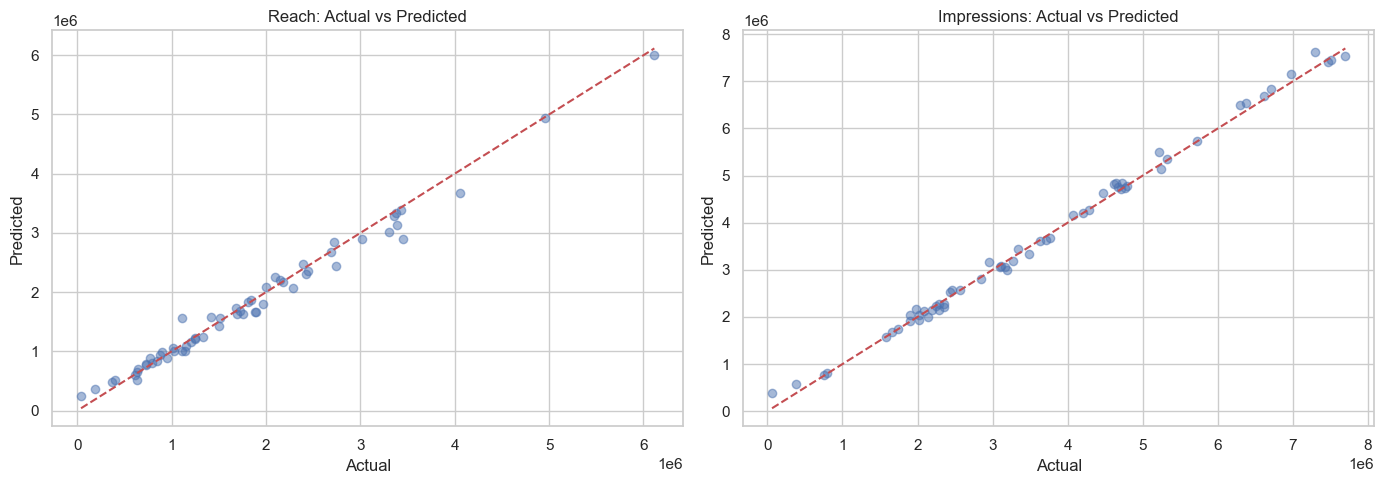

In [99]:
# Scatter plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].scatter(y_test.iloc[:, 0], y_pred[:, 0], alpha=0.5)
axs[0].plot([y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()], [y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()], 'r--')
axs[0].set_title("Reach: Actual vs Predicted")
axs[0].set_xlabel("Actual")
axs[0].set_ylabel("Predicted")

axs[1].scatter(y_test.iloc[:, 1], y_pred[:, 1], alpha=0.5)
axs[1].plot([y_test.iloc[:, 1].min(), y_test.iloc[:, 1].max()], [y_test.iloc[:, 1].min(), y_test.iloc[:, 1].max()], 'r--')
axs[1].set_title("Impressions: Actual vs Predicted")
axs[1].set_xlabel("Actual")
axs[1].set_ylabel("Predicted")

plt.tight_layout()
plt.show()

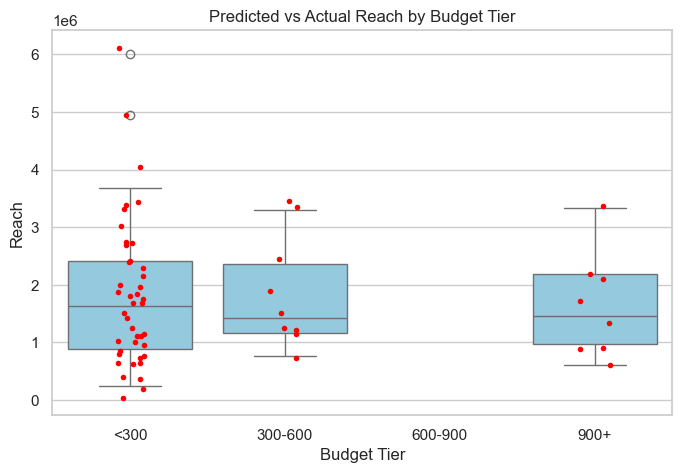

In [100]:
# Budget tier analysis
X_test_copy = X_test.copy()
X_test_copy['Amount spent'] = df.loc[X_test.index, 'Amount spent']
X_test_copy['Reach_true'] = y_test.iloc[:, 0]
X_test_copy['Reach_pred'] = y_pred[:, 0]
X_test_copy['tier'] = pd.cut(X_test_copy['Amount spent'], bins=[0, 300, 600, 900, np.inf], labels=['<300', '300-600', '600-900', '900+'])

plt.figure(figsize=(8, 5))
sns.boxplot(data=X_test_copy, x='tier', y='Reach_pred', color='skyblue')
sns.stripplot(data=X_test_copy, x='tier', y='Reach_true', color='red', size=4, jitter=True)
plt.title("Predicted vs Actual Reach by Budget Tier")
plt.ylabel("Reach")
plt.xlabel("Budget Tier")
plt.show()

In [101]:
# --- Step 7: Save Artifacts ---
joblib.dump(model, 'awareness_model.pkl')
joblib.dump(list(X.columns), 'awareness_model_features.pkl')

print("✅ Awareness model retrained and saved (no PowerTransformer).")

✅ Awareness model retrained and saved (no PowerTransformer).
